输出的为每一类的置信值$\bf y$

$$\hat{y}=\argmax _i{o_i}$$

对于特殊,要拉开距离
$$o_y-o_i\ge \Delta (y,i)$$

将结果转换为概率
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$$

信息熵
$$H[P] = \sum_j - P(j) \log P(j)$$
交叉熵
$$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j$$
$\bf y$是一个长度$q$为的独热编码向量,其中只有$y_y=1$

所以$l(\mathbf{y}, \hat{\mathbf{y}}) = -\log \hat{y}_y$

$$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}\end{split}\\
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.$$

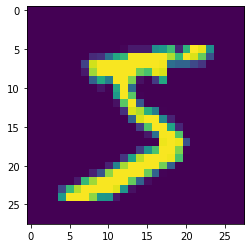

In [1]:
import mine_torch
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
from torch import nn

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="./data", train=False, transform=trans, download=True)
plt.imshow(mnist_train[0][0][0])
plt.show()

In [2]:
mnist_train[0][0]#第0维是某个example
#第一维为一个元组(data,lable)
#图像为(1,28,28),1代表单通道

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

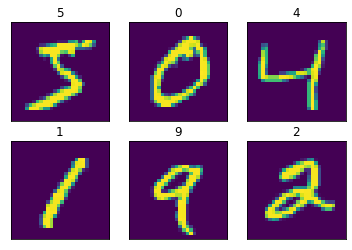

In [3]:
fig,axes=plt.subplots(2,3)
axes=axes.flatten()#一维
for i in range(6):
    ax=axes[i]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(mnist_train[i][0][0])
    ax.set_title(mnist_train[i][1])
plt.show()

In [4]:
batch_size=256
num_input=28*28
num_output=10

train_iter=data.DataLoader(mnist_train,256,True)
test_iter=data.DataLoader(mnist_test,256,True)
W=torch.normal(0,0.01,size=(num_input,num_output),requires_grad=True)
b=torch.zeros(num_output,requires_grad=True)

def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(dim=1,keepdim=True)#dim=0 列 1为行
    return X_exp/partition#广播机制 自动补全

def net(X):#数据(256*784) W(784,10)
    return softmax(torch.matmul(X.reshape((-1,num_input)),W)+b)


In [5]:
y = torch.tensor([0, 2])#直接写索引就行
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]#[y_hat[0,0],y_hat[1,2]]

tensor([0.1000, 0.5000])

In [6]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [7]:
def my_reshape(X):
    temp=[i[0].reshape(num_input) for i in X]
    res=torch.zeros(len(X),num_input)#形状必须完全一致

    for i in range(len(X)):
        res[i]=temp[i]
    return res

mnist_train_features=my_reshape(mnist_train)
mnist_test_features=my_reshape(mnist_test)
mnist_train_features.shape

torch.Size([60000, 784])

In [8]:

def one_hot_lables(X):#独热化标签
    lable_temp=torch.zeros(len(X),num_output)
    index=[i[1] for i in X]
    for i in range(len(X)):
        lable_temp[i][index[i]]=1
    return lable_temp
one_hot_lables(mnist_train).shape


torch.Size([60000, 10])

In [9]:
net(mnist_train_features)[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [10]:
def cal_acc(X,y):
    tot=0
    for i in range(X.shape[0]):
        if(net(X[i]).argmax()==y[i]):
            tot+=1
    return tot/X.shape[0]
#计算准确率

In [11]:
y_train=torch.tensor([i[1] for i in mnist_train])
y_test=torch.tensor([i[1] for i in mnist_test])

cal_acc(mnist_train_features,y_train)

0.10706666666666667

In [12]:
loss=cross_entropy(net(mnist_train_features),y_train).mean()

epochs=100
lr=0.08
acc=[]#准确率
length=len(mnist_train)
for epoch in range(epochs):
    loss=cross_entropy(net(mnist_train_features),y_train).mean()
    loss.backward()
    
    with torch.no_grad():#更新时不用计算梯度
        #非常重要
        W-=(W.grad)*lr
        W.grad.zero_()
        b-=(b.grad)*lr
        b.grad.zero_()
    if(epoch%10==0):
        acc.append(cal_acc(mnist_train_features,y_train))
    print(f'epoch {epoch + 1}, loss {loss.item():f}')



epoch 1, loss 2.298024
epoch 2, loss 2.212611
epoch 3, loss 2.133730
epoch 4, loss 2.060031
epoch 5, loss 1.990839
epoch 6, loss 1.925763
epoch 7, loss 1.864524
epoch 8, loss 1.806897
epoch 9, loss 1.752674
epoch 10, loss 1.701655
epoch 11, loss 1.653649
epoch 12, loss 1.608468
epoch 13, loss 1.565933
epoch 14, loss 1.525872
epoch 15, loss 1.488119
epoch 16, loss 1.452519
epoch 17, loss 1.418926
epoch 18, loss 1.387202
epoch 19, loss 1.357217
epoch 20, loss 1.328853
epoch 21, loss 1.301997
epoch 22, loss 1.276546
epoch 23, loss 1.252404
epoch 24, loss 1.229481
epoch 25, loss 1.207696
epoch 26, loss 1.186973
epoch 27, loss 1.167241
epoch 28, loss 1.148435
epoch 29, loss 1.130497
epoch 30, loss 1.113369
epoch 31, loss 1.097001
epoch 32, loss 1.081346
epoch 33, loss 1.066359
epoch 34, loss 1.052001
epoch 35, loss 1.038234
epoch 36, loss 1.025022
epoch 37, loss 1.012334
epoch 38, loss 1.000140
epoch 39, loss 0.988412
epoch 40, loss 0.977123
epoch 41, loss 0.966251
epoch 42, loss 0.955772
e

In [13]:
cal_acc(mnist_train_features,y_train)

0.8552166666666666

In [14]:
for i in range(50):
    print(f'predict:{net(mnist_train_features[i]).argmax()} real:{y_train[i]}')

predict:5 real:5
predict:0 real:0
predict:4 real:4
predict:1 real:1
predict:9 real:9
predict:2 real:2
predict:1 real:1
predict:3 real:3
predict:1 real:1
predict:4 real:4
predict:3 real:3
predict:2 real:5
predict:3 real:3
predict:6 real:6
predict:1 real:1
predict:7 real:7
predict:2 real:2
predict:8 real:8
predict:6 real:6
predict:7 real:9
predict:4 real:4
predict:0 real:0
predict:9 real:9
predict:1 real:1
predict:6 real:1
predict:2 real:2
predict:4 real:4
predict:3 real:3
predict:7 real:2
predict:7 real:7
predict:3 real:3
predict:8 real:8
predict:6 real:6
predict:7 real:9
predict:0 real:0
predict:5 real:5
predict:6 real:6
predict:0 real:0
predict:7 real:7
predict:6 real:6
predict:1 real:1
predict:8 real:8
predict:7 real:7
predict:9 real:9
predict:3 real:3
predict:9 real:9
predict:8 real:8
predict:5 real:5
predict:5 real:9
predict:3 real:3


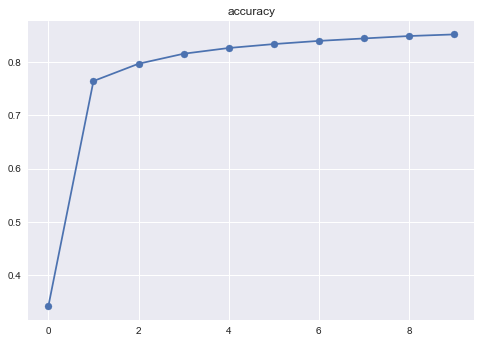

In [15]:
plt.style.use('seaborn')
fig,ax=plt.subplots()
ax.set_title("accuracy")
ax.scatter(range(int(epochs/10)),acc)
ax.plot(range(int(epochs/10)),acc)

In [16]:
cal_acc(mnist_test_features,y_test)

0.8648

In [17]:
#实现批量梯度下降
#ratio指acc的百分比
ratio=10
W=torch.normal(0,0.01,size=(num_input,num_output),requires_grad=True)
b=torch.zeros(num_output,requires_grad=True)

for epoch in range(epochs):
    out=mine_torch.select(mnist_train_features,y_train,256)
    loss=cross_entropy(net(out[0]),out[1]).mean()
    loss.backward()

    with torch.no_grad():#更新时不用计算梯度
        #非常重要
        W-=(W.grad)*lr
        W.grad.zero_()  
        b-=(b.grad)*lr
        b.grad.zero_()
    if(epoch%ratio==0):
        print(f'epoch {epoch }, accuracy {cal_acc(mnist_train_features,y_train):f}')


epoch 0, accuracy 0.349683
epoch 10, accuracy 0.747567
epoch 20, accuracy 0.794283
epoch 30, accuracy 0.805483
epoch 40, accuracy 0.818317
epoch 50, accuracy 0.832100
epoch 60, accuracy 0.834150
epoch 70, accuracy 0.843567
epoch 80, accuracy 0.850367
epoch 90, accuracy 0.850017


In [18]:
cal_acc(mnist_train_features,y_train)

0.8522

In [19]:
#简洁实现
# 将图片展平
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))
net[1].weight.data.normal_(0,0.01)

tensor([[-0.0004,  0.0135, -0.0215,  ...,  0.0055,  0.0064, -0.0034],
        [ 0.0114, -0.0013,  0.0094,  ..., -0.0012,  0.0072, -0.0104],
        [-0.0143,  0.0015,  0.0249,  ..., -0.0174,  0.0164, -0.0057],
        ...,
        [-0.0043,  0.0042,  0.0100,  ...,  0.0039, -0.0056, -0.0051],
        [-0.0125,  0.0099,  0.0010,  ..., -0.0012,  0.0108, -0.0112],
        [ 0.0235, -0.0099,  0.0093,  ..., -0.0098,  0.0084, -0.0042]])

In [20]:
loss=nn.CrossEntropyLoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.1)

In [21]:
i=0
for X, y in train_iter:#迭代器每次返回X和y
    l = loss(net(X) ,y)
    trainer.zero_grad()#清零梯度
    l.backward()
    trainer.step()#自动前进
    l = loss(net(mnist_train_features), y_train)#每轮再计算loss
    print(f'epoch {i + 1}, loss {l:f}')
    i+=1

epoch 1, loss 2.198996
epoch 2, loss 2.110306
epoch 3, loss 2.012805
epoch 4, loss 1.932960
epoch 5, loss 1.855852
epoch 6, loss 1.785201
epoch 7, loss 1.721590
epoch 8, loss 1.661037
epoch 9, loss 1.604266
epoch 10, loss 1.553753
epoch 11, loss 1.503500
epoch 12, loss 1.458217
epoch 13, loss 1.417983
epoch 14, loss 1.376527
epoch 15, loss 1.338860
epoch 16, loss 1.307583
epoch 17, loss 1.275011
epoch 18, loss 1.241011
epoch 19, loss 1.214283
epoch 20, loss 1.185017
epoch 21, loss 1.161221
epoch 22, loss 1.137506
epoch 23, loss 1.114617
epoch 24, loss 1.095041
epoch 25, loss 1.075628
epoch 26, loss 1.055705
epoch 27, loss 1.039978
epoch 28, loss 1.023703
epoch 29, loss 1.009192
epoch 30, loss 0.993098
epoch 31, loss 0.978209
epoch 32, loss 0.964902
epoch 33, loss 0.953392
epoch 34, loss 0.941091
epoch 35, loss 0.929619
epoch 36, loss 0.917405
epoch 37, loss 0.905104
epoch 38, loss 0.894440
epoch 39, loss 0.884973
epoch 40, loss 0.876351
epoch 41, loss 0.867675
epoch 42, loss 0.858731
e

In [22]:
net(mnist_test_features[0].unsqueeze(0))#在0维上升维

tensor([[-0.2152, -3.4967, -0.6406,  0.8267, -0.6291, -1.0345, -2.7525,  6.1915,
         -0.4394,  1.9429]], grad_fn=<AddmmBackward0>)

In [23]:
def torch_cal_acc(X,y):
    tot=0
    for i in range(X.shape[0]):
        if(net(X[i].unsqueeze(0)).argmax()==y[i]):
            tot+=1
    return tot/X.shape[0]

torch_cal_acc(mnist_test_features,y_test)

0.8856